In [21]:
import pandas as pd

df = pd.read_csv("synthetic_insurance_dirty.csv")

print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())


(510, 6)
    Age  Gender Policy_Type Medical_History  Premium  Claim
0  56.0       M    Standard            NONE   6845.0    1.0
1  69.0       M         NaN             NaN   5246.0    0.0
2  46.0  Female         NaN            NONE   2940.0    1.0
3  32.0  FEMALE    Standard           Heart   5506.0    0.0
4  60.0  Female         NaN        Diabetes   4761.0    1.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              509 non-null    float64
 1   Gender           510 non-null    object 
 2   Policy_Type      407 non-null    object 
 3   Medical_History  348 non-null    object 
 4   Premium          508 non-null    float64
 5   Claim            505 non-null    float64
dtypes: float64(3), object(3)
memory usage: 24.0+ KB
None
Age                  1
Gender               0
Policy_Type        103
Medical_History    162
Premium  

In [22]:
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Premium'] = df['Premium'].fillna(df['Premium'].median())
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Policy_Type'] = df['Policy_Type'].fillna(df['Policy_Type'].mode()[0])
df['Medical_History'] = df['Medical_History'].fillna(df['Medical_History'].mode()[0])
df['Claim'] = df['Claim'].fillna(0)

In [23]:
# Normalize Gender
df['Gender'] = df['Gender'].str.upper().replace({
    'M': 'MALE', 'F': 'FEMALE', 'MALE': 'MALE', 'FEMALE': 'FEMALE'
})

# Normalize Policy Type
df['Policy_Type'] = df['Policy_Type'].str.title().replace({
    'Basics': 'Basic'
})

# Normalize Medical History
df['Medical_History'] = df['Medical_History'].str.title().replace({
    'None': 'None'
})


In [24]:
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
df = df[(df['Premium'] > 0) & (df['Premium'] < 100000)]


In [25]:
df.drop_duplicates(inplace=True)


In [26]:
df['Gender'] = df['Gender'].map({'MALE': 0, 'FEMALE': 1})
df['Policy_Type'] = df['Policy_Type'].map({'Basic': 0, 'Standard': 1, 'Premium': 2})
df['Medical_History'] = df['Medical_History'].map({'None': 0, 'Diabetes': 1, 'Heart': 2, 'Chronic': 3})


In [27]:
print(df.info())
print(df.describe())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 493 entries, 0 to 499
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Age              493 non-null    float64
 1   Gender           493 non-null    int64  
 2   Policy_Type      493 non-null    int64  
 3   Medical_History  493 non-null    int64  
 4   Premium          493 non-null    float64
 5   Claim            493 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 27.0 KB
None
              Age      Gender  Policy_Type  Medical_History      Premium  \
count  493.000000  493.000000   493.000000       493.000000   493.000000   
mean    50.162272    0.501014     0.817444         1.985801  4927.991886   
std     18.453249    0.500507     0.742948         1.179862  1484.290741   
min     18.000000    0.000000     0.000000         0.000000  2201.000000   
25%     35.000000    0.000000     0.000000         1.000000  3924.000000   
50%     50.000000    

In [10]:
print(df.isnull().sum()) 

Age                0
Gender             0
Policy_Type        0
Medical_History    0
Premium            0
Claim              0
dtype: int64


In [38]:
# --- Step 2: Define Rule-Based Risk Scoring ---
def risk_score(row):
    score = 0

    # Age scoring
    if row['Age'] < 25:
        score += 1
    elif 25 <= row['Age'] <= 40:
        score += 2
    elif 41 <= row['Age'] <= 60:
        score += 3
    else:
        score += 4

    # Gender scoring
    if row['Gender'] == "Male":
        score += 2
    elif row['Gender'] == "Female":
        score += 1

    # Policy type scoring
    if row['Policy_Type'] == "Premium":
        score += 2
    elif row['Policy_Type'] == "Basic":
        score += 1

    # Medical history scoring
    if row['Medical_History'] == "Yes":
        score += 3
    else:
        score += 1

    # Claim scoring (instead of Previous_Claim)
    if row['Claim'] == 1:
        score += 3
    else:
        score += 1

    # Premium amount scoring
    if row['Premium'] < 5000:
        score += 1
    elif 5000 <= row['Premium'] <= 20000:
        score += 2
    else:
        score += 3

    return score

df['Risk_Score'] = df.apply(risk_score, axis=1)

# --- Step 3: Convert Risk Score → Risk Level ---
def risk_level(score):
    if score <= 7:
        return "Low"
    elif 8 <= score <= 11:
        return "Medium"
    else:
        return "High"

df['Predicted_Risk'] = df['Risk_Score'].apply(risk_level)

# --- Step 4: Save Results ---
df.to_csv("insurance_with_predictions.csv", index=False)

print(df[['Age', 'Gender', 'Policy_Type', 'Medical_History', 'Claim',
          'Premium', 'Risk_Score', 'Predicted_Risk']].head(10))


     Age  Gender  Policy_Type  Medical_History  Claim  Premium  Risk_Score  \
0   56.0       0            1                0    1.0   6845.0           9   
1   69.0       0            1                3    0.0   5246.0           8   
2   46.0       1            1                0    1.0   2940.0           8   
3   32.0       1            1                2    0.0   5506.0           6   
4   60.0       1            1                1    1.0   4761.0           8   
5   25.0       0            2                2    1.0   8046.0           8   
6   78.0       1            1                3    0.0   5881.0           8   
7   38.0       0            1                3    0.0   4788.0           5   
8   56.0       1            1                0    1.0   4400.0           8   
10  36.0       0            0                0    0.0   4370.0           5   

   Predicted_Risk  
0          Medium  
1          Medium  
2          Medium  
3             Low  
4          Medium  
5          Medium  
6

In [39]:
def predict_claim_risk(age, gender, policy_type, medical_history, premium, claim):
    score = 0

    # Age scoring
    if age < 25:
        score += 1
    elif 25 <= age <= 40:
        score += 2
    elif 41 <= age <= 60:
        score += 3
    else:
        score += 4

    # Gender scoring
    if gender == "Male":
        score += 2
    elif gender == "Female":
        score += 1

    # Policy type scoring
    if policy_type == "Premium":
        score += 2
    elif policy_type == "Basic":
        score += 1

    # Medical history scoring
    if medical_history == "Yes":
        score += 3
    else:
        score += 1

    # Claim scoring
    if claim == 1:
        score += 3
    else:
        score += 1

    # Premium amount scoring
    if premium < 5000:
        score += 1
    elif 5000 <= premium <= 20000:
        score += 2
    else:
        score += 3

    # Map score → Risk Level
    if score <= 7:
        return "Low Risk"
    elif 8 <= score <= 12:
        return "Medium Risk"
    else:
        return "High Risk"


In [40]:
print(predict_claim_risk(55, "Male", "Premium", "Diabetes", 800, 0))


print(predict_claim_risk(30, "Female", "Basic", "None", 400, 0))



Medium Risk
Low Risk


In [42]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Example: Map Predicted_Risk → Predicted_Claim
risk_mapping = {"High": 1, "Medium": 1, "Low": 0}

# Convert risk levels into claim prediction
df["Predicted_Claim"] = df["Predicted_Risk"].map(risk_mapping)

# Handle any unmapped values (NaN) by defaulting to 0 (no claim)
df["Predicted_Claim"] = df["Predicted_Claim"].fillna(0)

# Convert Claim column to integer (if not already)
df["Claim"] = df["Claim"].astype(int)
df["Predicted_Claim"] = df["Predicted_Claim"].astype(int)

# ✅ Model Evaluation
accuracy = accuracy_score(df["Claim"], df["Predicted_Claim"])
print("Model Accuracy:", accuracy)

print("\nConfusion Matrix:")
print(confusion_matrix(df["Claim"], df["Predicted_Claim"]))

print("\nClassification Report:")
print(classification_report(df["Claim"], df["Predicted_Claim"]))


Model Accuracy: 0.8255578093306288

Confusion Matrix:
[[211  30]
 [ 56 196]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       241
           1       0.87      0.78      0.82       252

    accuracy                           0.83       493
   macro avg       0.83      0.83      0.83       493
weighted avg       0.83      0.83      0.83       493



In [43]:
print(predict_claim_risk(65, "Male", "Premium", "Asthma", 25000, 1))


High Risk


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns


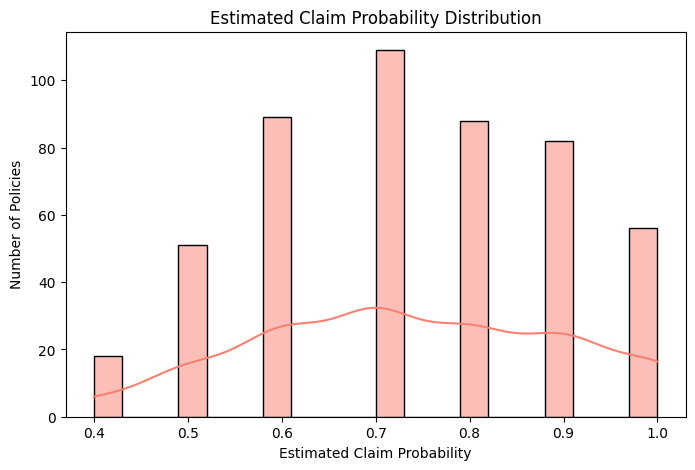

In [47]:
df['Claim_Probability'] = df['Risk_Score'] / df['Risk_Score'].max()

plt.figure(figsize=(8,5))
sns.histplot(df['Claim_Probability'], bins=20, kde=True, color='salmon')
plt.title("Estimated Claim Probability Distribution")
plt.xlabel("Estimated Claim Probability")
plt.ylabel("Number of Policies")
plt.show()


C:\Users\madhu\AppData\Local\Temp\ipykernel_5916\2719550129.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Risk Level")


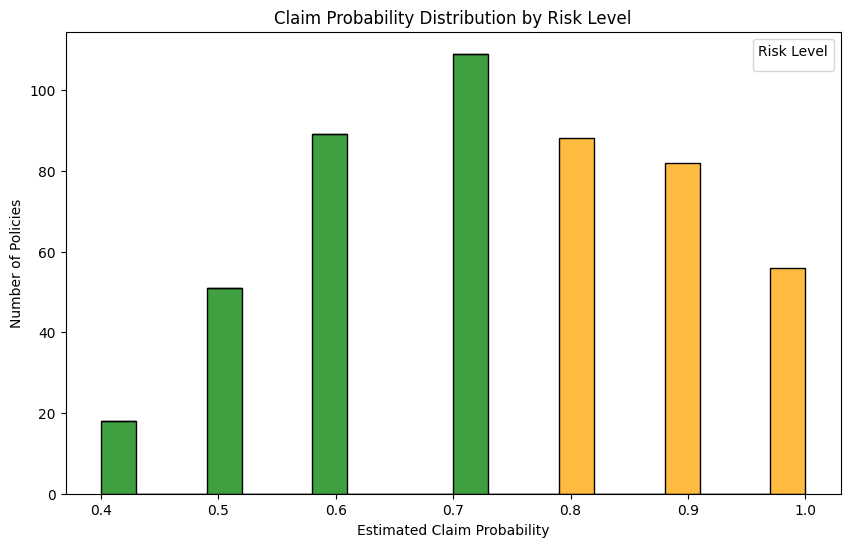

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assign colors for risk levels
risk_colors = {'Low': 'green', 'Medium': 'orange', 'High': 'red'}

plt.figure(figsize=(10,6))

# Plot histogram of Claim Probability
sns.histplot(df, x='Claim_Probability', bins=20, hue='Predicted_Risk',
             multiple='stack', palette=risk_colors, edgecolor='black')

plt.title("Claim Probability Distribution by Risk Level")
plt.xlabel("Estimated Claim Probability")
plt.ylabel("Number of Policies")
plt.legend(title="Risk Level")
plt.show()
